In [24]:
import numpy as np 
import polars as pl
import random
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
!pip install tqdm
from tqdm import tqdm

fish is now exiting


In [28]:
class Agent:
    def __init__(self, max_bid, learning_rate, discount_factor):
        self.q_table = np.zeros((max_bid+1, max_bid+1))  # (type, bid)
        self.max_bid = max_bid
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor

    def choose_action(self, state, epsilon):
        if random.random() < epsilon:
            return random.randint(0, self.max_bid)
        else:
            return np.argmax(self.q_table[state])

    def update_q_table(self, state, action, reward, next_state):
        best_next_action = np.argmax(self.q_table[next_state])
        self.q_table[state, action] += self.learning_rate * (reward + self.discount_factor * self.q_table[next_state, best_next_action] - self.q_table[state, action])

class AuctionEnvironment:
    def __init__(self, max_bid):
        self.max_bid = max_bid

    def get_types(self):
        return random.randint(1, self.max_bid), random.randint(1, self.max_bid)

    def determine_payouts(self, bid1, bid2):
        if bid1 > bid2:
            return bid2, 0
        elif bid2 > bid1:
            return 0, bid1
        else:
            # If there's a tie, no one wins
            return 0, 0

def simulate_auction(agent1, agent2, env, epsilon):
    type1, type2 = env.get_types()
    action1 = agent1.choose_action(type1, epsilon)
    action2 = agent2.choose_action(type2, epsilon)
    payout1, payout2 = env.determine_payouts(action1, action2)
    reward1 = type1 - payout1 if payout1 > 0 else 0
    reward2 = type2 - payout2 if payout2 > 0 else 0
    agent1.update_q_table(type1, action1, reward1, type1)
    agent2.update_q_table(type2, action2, reward2, type2)
    return type1, action1, reward1, type2, action2, reward2


def train_agents(num_epochs, num_episodes, agent1, agent2, env, epsilon):
    results = []
    for epoch in tqdm(range(num_epochs), desc='Epoch Progress'):
        for episode in tqdm(range(num_episodes), desc='Episode Progress', leave=False):
            result = simulate_auction(agent1, agent2, env, epsilon)
            results.append([epoch, episode] + list(result))
    return results

# Parameters
max_bid = 100
learning_rate = 0.05
discount_factor = 0.95
epsilon = 0.1
num_epochs = int(1e4)
num_episodes = int(5e3)



# Initialize agents and environment
agent1 = Agent(max_bid, learning_rate, discount_factor)
agent2 = Agent(max_bid, learning_rate, discount_factor)
env = AuctionEnvironment(max_bid)

# Training
training_data = train_agents(num_epochs, num_episodes, agent1, agent2, env, epsilon)

# Convert training data to Polars DataFrame
df_columns = ['epoch', 'episode', 'type1', 'bid1', 'reward1', 'type2', 'bid2', 'reward2']
df_dict = {name: [] for name in df_columns}
for data in training_data:
    for i, value in enumerate(data):
        df_dict[df_columns[i]].append(value)

df = pl.DataFrame(df_dict)

Epoch Progress: 100%|██████████| 10000/10000 [15:21<00:00, 10.85it/s]


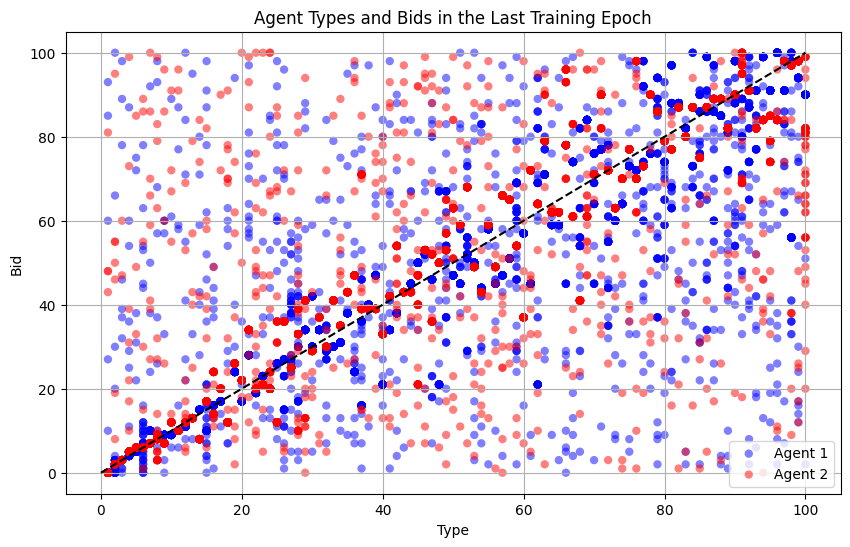

In [34]:

# Find the maximum epoch value
max_epoch = df['epoch'].max()

# Filter the DataFrame to only include data from the last epoch
last_epoch_data = df.filter(pl.col('epoch') == max_epoch)

# Create a scatter plot
plt.figure(figsize=(10, 6))

# Plot type1 vs bid1 for the last epoch
plt.scatter(last_epoch_data['type1'], last_epoch_data['bid1'], color='blue', alpha=0.5, edgecolor='none', label='Agent 1')

# Plot type2 vs bid2 for the last epoch
plt.scatter(last_epoch_data['type2'], last_epoch_data['bid2'], color='red', alpha=0.5, edgecolor='none', label='Agent 2')

# Setting plot labels and title
plt.xlabel('Type')
plt.ylabel('Bid')
plt.title('Agent Types and Bids in the Last Training Epoch')
plt.legend()
plt.grid(True)

# add line of y=x
plt.plot([0, 100], [0, 100], color='black', linestyle='--')

# Display the plot
plt.show()

In [35]:
# Save the dataframe as a csv file
df.write_csv('SPA_bids_and_types.csv')